## Figure 2A, 2C, 4
## Figure S4C, S6B, S6C

## Helper codes: run below cells before any of the other cells. 

In [4]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mode, spearmanr, sem, pearsonr
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import seaborn as sns
from copy import deepcopy as dc
from statsmodels.stats.multitest import multipletests
from itertools import combinations, product, permutations, combinations_with_replacement
import math
import time
import random
import networkx as nx

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.multiclass import OneVsOneClassifier
from sklearn.manifold import Isomap

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

In [5]:
# loading variables

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()

In [6]:
with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_HVA_names = dc(resp_matrix_ep_HVA_allensdk['list_HVA_names'])
    list_rate_all_HVA = dc(resp_matrix_ep_HVA_allensdk['list_rate_all_HVA'])
    list_slopes_all_an_loglog_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_all_an_loglog_HVA'])
    list_empty_sess2 = dc(resp_matrix_ep_HVA_allensdk['list_empty_sess2'])
    list_slopes_flattened2 = dc(resp_matrix_ep_HVA_allensdk['list_slopes_flattened2'])
    
# with open('resp_matrix_ep_HVA_allensdk.pickle', 'wb') as f:
#     pickle.dump({'tree_variables': ['list_HVA_names', 'list_rate_all_HVA', 'list_empty_sess2', 'list_num_neurons_HVA', 'list_slopes_all_an_loglog_HVA', 'list_slopes_flattened2'],
#                  'list_HVA_names': list_HVA_names, 'list_rate_all_HVA': list_rate_all_HVA, 'list_empty_sess2': list_empty_sess2,
#                  'list_num_neurons_HVA': list_num_neurons_HVA, 'list_slopes_all_an_loglog_HVA': list_slopes_all_an_loglog_HVA, 'list_slopes_flattened2': list_slopes_flattened2}, f)

In [7]:
with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_rate_all_HVA = dc(resp_matrix_ep_HVA_allensdk['list_rate_all_HVA'])
    list_slopes_all_an_loglog_HVA = dc(resp_matrix_ep_HVA_allensdk['list_slopes_all_an_loglog_HVA'])

# Iterate over all visual areas (V1 + 5 HVAs)

num_sess = 32

list_vis_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_lowq_sess_HVA = {hva: np.full(num_sess, np.nan) for hva in list_HVA_names}
for area_ind, area in enumerate(list_HVA_names):

    # Iterate over all sessions
    list_slopes_all_an_loglog = np.empty(num_sess, dtype=object)
    # list_neu_fit_error2 = np.empty(num_sess, dtype=object)
    # list_mask_ind = np.empty(num_sess, dtype=object)
    # list_mask_neu_ind = np.empty(num_sess, dtype=object)
    for sess_ind in range(num_sess):
        # print(f'session index: {sess_ind}')
            
        rate = list_rate_all_HVA[area][sess_ind].copy()
        
        if np.any(rate) == True: # if neurons exist
            rate = rate.sort_index(axis=1)
            stm = rate.columns.copy()

            # Multiply by delta t to convert to spike counts
            rate = rate * 0.25

            list_lowq_sess_HVA[area][sess_ind] = np.all(rate == 0, axis=0).sum() / rate.shape[1]

In [8]:
num_sess = 32
list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']
list_num_neurons_HVA = {hva: np.zeros(num_sess) for hva in list_HVA_names}
for area_ind, area in enumerate(list_HVA_names):
	print(f'area {area}')
	for sess_ind in range(num_sess):
		if np.any(list_rate_all_HVA[area][sess_ind]) == True:
		    # print(list_rate_all_HVA[area][sess_ind].shape[0]) # 6 10 13 8 17 sessions have >=50 neurons
			list_num_neurons_HVA[area][sess_ind] = list_rate_all_HVA[area][sess_ind].shape[0]

area VISl
area VISrl
area VISal
area VISpm
area VISam


In [9]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [10]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [11]:
# Function to compute cosine similarity
def cos_sim(x, y):
    # x and y are 1D vectors

    # Remove NaN
    x, y = np.array(x), np.array(y)
    bool_notnan = np.logical_and(~np.isnan(x), ~np.isnan(y))
    x, y = x[bool_notnan].copy(), y[bool_notnan].copy()

    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [12]:
# Function for column normalization
def normc(matrix):
    '''For 2D matrix'''

    matrix_normalized = matrix / np.linalg.norm(matrix, axis=0)

    return matrix_normalized

In [13]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

In [14]:
# # Collect overlap for each session
     
# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119
# num_sampling = 10

# list_overlap_asis3 = np.full((num_sess, num_sampling, 2, num_trial_types, num_trial_types), np.nan) # 2 neuronal subsets
# list_overlap_RRneuron4 = np.full((num_sess, num_sampling, len(list_target_slopes), 2, num_trial_types, num_trial_types), np.nan)
# list_gap_asis3 = np.full((num_sess, num_sampling, 2, num_trial_types, num_trial_types), np.nan) # 2 neuronal subsets
# list_gap_RRneuron4 = np.full((num_sess, num_sampling, len(list_target_slopes), 2, num_trial_types, num_trial_types), np.nan)
# for sess_ind in range(num_sess):
#     file_name = 'overlap_nbr_stimpairs_consis_ABO_' + str(sess_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         overlap_stimpairs_ABO = pickle.load(f)
#         list_overlap_asis3[sess_ind] = overlap_stimpairs_ABO['list_overlap_asis2'].copy()
#         list_overlap_RRneuron4[sess_ind] = overlap_stimpairs_ABO['list_overlap_RRneuron3'].copy()
#         list_gap_asis3[sess_ind] = overlap_stimpairs_ABO['list_gap_asis2'].copy()
#         list_gap_RRneuron4[sess_ind] = overlap_stimpairs_ABO['list_gap_RRneuron3'].copy()

# save_file_name = 'overlap_nbr_stimpairs_consis_ABO_all3.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_overlap_asis3', 'list_overlap_RRneuron4', 'list_gap_asis3', 'list_gap_RRneuron4'],
#                     'list_overlap_asis3': list_overlap_asis3, 'list_overlap_RRneuron4': list_overlap_RRneuron4,
#                     'list_gap_asis3': list_gap_asis3, 'list_gap_RRneuron4': list_gap_RRneuron4}, f)

## Codes for figures

## Figure 4A

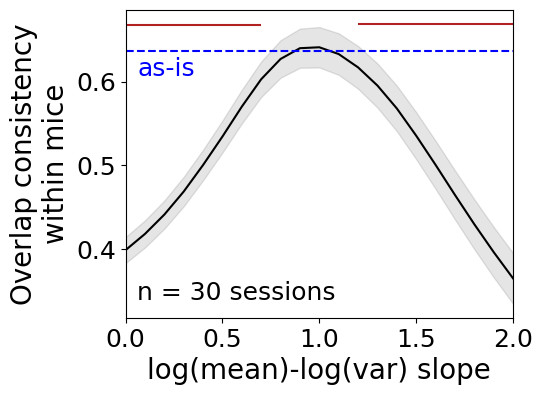

In [15]:
# overlap consistency

save_file_name = 'overlap_nbr_stimpairs_consis_ABO_all3.pickle' # num_trial_types x num_trial_types, overlap (minimum distance) & gap (minimum distance), with diagonal, slope 0-2
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    overlap_stimpairs_ABO_all = pickle.load(f)
    
    list_overlap_asis3 = dc(overlap_stimpairs_ABO_all['list_overlap_asis3'])
    list_overlap_RRneuron4 = dc(overlap_stimpairs_ABO_all['list_overlap_RRneuron4'])
    list_gap_asis3 = dc(overlap_stimpairs_ABO_all['list_gap_asis3'])
    list_gap_RRneuron4 = dc(overlap_stimpairs_ABO_all['list_gap_RRneuron4'])

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
num_sess = 32
num_trial_types = 119
num_sampling = 10

# num_trial_types x num_trial_types
list_overlap_consis_asis = np.full((num_sess, num_sampling), np.nan) # correlation between 2 neuronal subset
for sess_ind in range(num_sess):
    for sampling_ind in range(num_sampling):

        overlap_mat1 = list_overlap_asis3[sess_ind, sampling_ind, 0].flatten()
        overlap_mat2 = list_overlap_asis3[sess_ind, sampling_ind, 1].flatten()
        
        list_overlap_consis_asis[sess_ind, sampling_ind] = spearmanr(overlap_mat1, overlap_mat2)[0]

list_overlap_consis_RRneuron2 = np.full((num_sess, num_sampling, len(list_target_slopes)), np.nan) # correlation between 2 neuronal subset
for sess_ind in range(num_sess):
    for sampling_ind in range(num_sampling):
        for slope_ind in range(len(list_target_slopes)):

            overlap_mat1 = list_overlap_RRneuron4[sess_ind, sampling_ind, slope_ind, 0].flatten()
            overlap_mat2 = list_overlap_RRneuron4[sess_ind, sampling_ind, slope_ind, 1].flatten()

            list_overlap_consis_RRneuron2[sess_ind, sampling_ind, slope_ind] = spearmanr(overlap_mat1, overlap_mat2)[0]

list_overlap_consis_asis = list_overlap_consis_asis.mean(axis=1)
list_overlap_consis_RRneuron2 = list_overlap_consis_RRneuron2.mean(axis=1)

# Exclude low quality sessions (0, 6)
list_overlap_consis_asis = np.concatenate([list_overlap_consis_asis[1:6], list_overlap_consis_asis[7:]], axis=0)
list_overlap_consis_RRneuron2 = np.concatenate([list_overlap_consis_RRneuron2[1:6], list_overlap_consis_RRneuron2[7:]], axis=0)

# Wilcoxon signed-rank test (across sessions)
list_pvals_overlap_consis = np.array([list(wilcoxon(list_overlap_consis_asis, list_overlap_consis_RRneuron2[:, slope_ind], nan_policy='omit'))[1]
                                      for slope_ind in range(len(list_target_slopes))])
list_pvals_overlap_consis = np.array(multipletests(list_pvals_overlap_consis, method='holm')[1]) # multiple comparisons correction
list_sig_slopes_overlap_consis = list_target_slopes[list_pvals_overlap_consis < 0.05].copy()

# line plot

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_means_overlap_consis = np.nanmean(list_overlap_consis_RRneuron2, axis=0)
list_errs_overlap_consis = sem(list_overlap_consis_RRneuron2, axis=0)

ax.plot(list_target_slopes, list_means_overlap_consis, color='k')
ax.fill_between(list_target_slopes, list_means_overlap_consis-list_errs_overlap_consis, list_means_overlap_consis+list_errs_overlap_consis, color='k', alpha=0.1)

ax.axhline(np.nanmean(list_overlap_consis_asis), color='b', linestyle='--') # as-is average

# significance
# ax.set_ylim(ax.get_ylim()[0], 0.42)
annotate_lineplot_significance(list_sig_slopes_overlap_consis, axes=ax, ax_ind=0, line_height_ratio=0.96, color='firebrick')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
# ax.set_ylabel(f'Overlap consistency\nbetween neuronal subsets', fontsize=17)
ax.set_ylabel(f'Overlap consistency\nwithin mice', fontsize=20)
ax.tick_params('both', labelsize=18)

height = (np.nanmean(list_overlap_consis_asis)-ax.get_ylim()[0]) / (ax.get_ylim()[1]-ax.get_ylim()[0])
ax.annotate('as-is', xy=(0.03, height-0.08), xycoords='axes fraction', fontsize=18, color='b')
ax.annotate(f'n = {list_overlap_consis_asis.shape[0]} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

ax.set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\overlap_consis_within.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\overlap_consis_within.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# # Collect overlap for each session
     
# list_target_slopes = [0, 1, 2]
# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119
# box_size = 20

# list_mean_dist_mat = np.full((num_sess, num_trial_types, num_trial_types), np.nan)

# list_overlap_asis2 = np.zeros((num_sess, len(list(combinations(range(num_trial_types), 2)))))
# list_overlap_RRneuron3 = np.zeros((num_sess, len(list_target_slopes), len(list(combinations(range(num_trial_types), 2)))))

# list_overlap_asis2 = np.empty(num_sess, dtype=object)
# list_overlap_RRneuron3 = np.empty(num_sess, dtype=object)

# list_overlap_asis2 = np.full((num_sess, num_trial_types, num_trial_types), np.nan)
# list_overlap_RRneuron3 = np.full((num_sess, len(list_target_slopes), num_trial_types, num_trial_types), np.nan)
# list_gap_asis2 = np.full((num_sess, num_trial_types, num_trial_types), np.nan)
# list_gap_RRneuron3 = np.full((num_sess, len(list_target_slopes), num_trial_types, num_trial_types), np.nan)
# for sess_ind in range(num_sess):
#     file_name = 'overlap_nbr_stimpairs_ABO_' + str(sess_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         overlap_stimpairs_ABO = pickle.load(f)
#         list_mean_dist_mat[sess_ind] = overlap_stimpairs_ABO['mean_dist_mat_asis'].copy()
#         list_overlap_asis2[sess_ind] = overlap_stimpairs_ABO['list_overlap_asis'].copy()
#         list_overlap_RRneuron3[sess_ind] = overlap_stimpairs_ABO['list_overlap_RRneuron2'].copy()
#         list_gap_asis2[sess_ind] = overlap_stimpairs_ABO['list_gap_asis'].copy()
#         list_gap_RRneuron3[sess_ind] = overlap_stimpairs_ABO['list_gap_RRneuron2'].copy()

# save_file_name = 'overlap_stimpairs_ABO_all_box' + str(box_size) + '.pickle'
# save_file_name = 'overlap_1d_stimpairs_ABO_all2.pickle'
# save_file_name = 'overlap_nbr_stimpairs_ABO_all22.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_mean_dist_mat', 'list_overlap_asis2', 'list_overlap_RRneuron3', 'list_gap_asis2', 'list_gap_RRneuron3'], \
#                  'list_mean_dist_mat': list_mean_dist_mat, 'list_overlap_asis2': list_overlap_asis2, 'list_overlap_RRneuron3': list_overlap_RRneuron3,
#                  'list_gap_asis2': list_gap_asis2, 'list_gap_RRneuron3': list_gap_RRneuron3}, f)

## Figure 2A, 4D

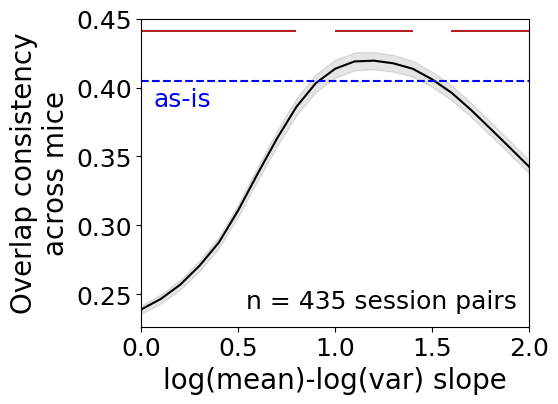

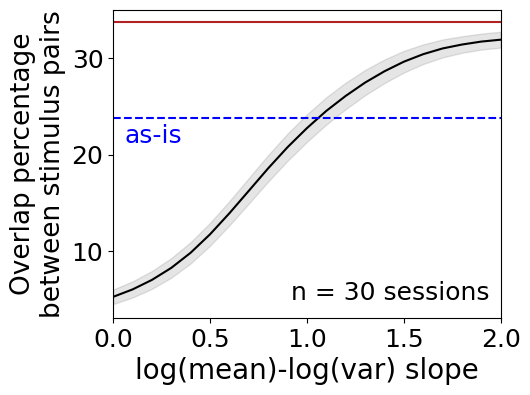

In [16]:
# overlap consistency across session pairs

save_file_name = 'overlap_nbr_stimpairs_ABO_all22.pickle' # num_trial_types x num_trial_types, overlap (minimum distance) & gap (5% of 5nn average distance), with diagonal, slope 0-2
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
	overlap_stimpairs_ABO_all = pickle.load(f)
	
	list_mean_dist_mat = dc(overlap_stimpairs_ABO_all['list_mean_dist_mat'])
	list_overlap_asis2 = dc(overlap_stimpairs_ABO_all['list_overlap_asis2'])
	list_overlap_RRneuron3 = dc(overlap_stimpairs_ABO_all['list_overlap_RRneuron3'])

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
num_sess = 32
num_trial_types = 119

# num_trial_types x num_trial_types
sess_pairs = list(combinations(range(num_sess), 2))
list_overlap_consis_asis = np.full(len(sess_pairs), np.nan) # session pair correlation
for pair_ind, pair in enumerate(sess_pairs):

    overlap_mat1 = list_overlap_asis2[pair[0]].flatten()
    overlap_mat2 = list_overlap_asis2[pair[1]].flatten()
    
    list_overlap_consis_asis[pair_ind] = spearmanr(overlap_mat1, overlap_mat2)[0]

list_overlap_consis_RRneuron2 = np.full((len(sess_pairs), len(list_target_slopes)), np.nan) # session pair correlation
for pair_ind, pair in enumerate(sess_pairs):
    for slope_ind in range(len(list_target_slopes)):

        overlap_mat1 = list_overlap_RRneuron3[pair[0], slope_ind].flatten()
        overlap_mat2 = list_overlap_RRneuron3[pair[1], slope_ind].flatten()

        list_overlap_consis_RRneuron2[pair_ind, slope_ind] = spearmanr(overlap_mat1, overlap_mat2)[0]

# Exclude low quality sessions (0, 6)
sess_pairs = np.array(list(combinations(range(num_sess), 2)))
mask_06 = ~np.any(np.isin(sess_pairs, [0, 6]), axis=1)
list_overlap_consis_asis = list_overlap_consis_asis[mask_06].copy()
list_overlap_consis_RRneuron2 = list_overlap_consis_RRneuron2[mask_06].copy()

mask_06 = ~np.isin(range(num_sess), [0, 6])
list_overlap_asis2 = list_overlap_asis2[mask_06].copy()
list_overlap_RRneuron3 = list_overlap_RRneuron3[mask_06].copy()

num_sess = list_overlap_asis2.shape[0]

# Wilcoxon signed-rank test (across sessions)
list_pvals_overlap_consis = np.array([list(wilcoxon(list_overlap_consis_asis, list_overlap_consis_RRneuron2[:, slope_ind], nan_policy='omit'))[1]
                                      for slope_ind in range(len(list_target_slopes))])
list_pvals_overlap = np.array([list(wilcoxon(list_overlap_asis2.mean(axis=(1, 2)), list_overlap_RRneuron3[:, slope_ind].mean(axis=(1, 2)), nan_policy='omit'))[1]
                                      for slope_ind in range(len(list_target_slopes))])
list_pvals_overlap_consis = np.array(multipletests(list_pvals_overlap_consis, method='holm')[1]) # multiple comparisons correction
list_pvals_overlap = np.array(multipletests(list_pvals_overlap, method='holm')[1]) # multiple comparisons correction

list_sig_slopes_overlap_consis = list_target_slopes[list_pvals_overlap_consis < 0.05].copy()
list_sig_slopes_overlap = list_target_slopes[list_pvals_overlap < 0.05].copy()

# 1. line plot (overlap consistency)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_means_overlap_consis = np.nanmean(list_overlap_consis_RRneuron2, axis=0)
list_errs_overlap_consis = sem(list_overlap_consis_RRneuron2, axis=0)

ax.plot(list_target_slopes, list_means_overlap_consis, color='k')
ax.fill_between(list_target_slopes, list_means_overlap_consis-list_errs_overlap_consis, list_means_overlap_consis+list_errs_overlap_consis, color='k', alpha=0.1)

ax.axhline(np.nanmean(list_overlap_consis_asis), color='b', linestyle='--') # as-is average

# significance
ax.set_ylim(ax.get_ylim()[0], 0.45)
annotate_lineplot_significance(list_sig_slopes_overlap_consis, axes=ax, ax_ind=0, line_height_ratio=0.96, color='firebrick')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
# ax.set_ylabel(f'Overlap consistency\nbetween session pairs', fontsize=20)
ax.set_ylabel(f'Overlap consistency\nacross mice', fontsize=20)
ax.tick_params('both', labelsize=18)

height = (np.nanmean(list_overlap_consis_asis)-ax.get_ylim()[0]) / (ax.get_ylim()[1]-ax.get_ylim()[0])
ax.annotate('as-is', xy=(0.03, height-0.08), xycoords='axes fraction', fontsize=18, color='b')
ax.annotate(f'n = {list_overlap_consis_asis.shape[0]} session pairs', xy=(0.27, 0.06), xycoords='axes fraction', fontsize=18, color='k')

ax.set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\overlap_consis_across.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\overlap_consis_across.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. line plot (overlap)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_means_overlap = 100*np.nanmean(list_overlap_RRneuron3, axis=(0, 2, 3)) 
list_errs_overlap = 100*sem(list_overlap_RRneuron3.mean(axis=(2, 3)), axis=0)

ax.plot(list_target_slopes, list_means_overlap, color='k')
ax.fill_between(list_target_slopes, list_means_overlap-list_errs_overlap, list_means_overlap+list_errs_overlap, color='k', alpha=0.1)

ax.axhline(100*np.nanmean(list_overlap_asis2), color='b', linestyle='--') # as-is average

# significance
ax.set_ylim(ax.get_ylim()[0], 35)
annotate_lineplot_significance(list_sig_slopes_overlap, axes=ax, ax_ind=0, line_height_ratio=0.96, color='firebrick')

ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel(f'Overlap percentage\nbetween stimulus pairs', fontsize=19)
ax.tick_params('both', labelsize=18)

height = (100*np.nanmean(list_overlap_asis2)-ax.get_ylim()[0]) / (ax.get_ylim()[1]-ax.get_ylim()[0])
ax.annotate('as-is', xy=(0.03, height-0.08), xycoords='axes fraction', fontsize=18, color='b')
ax.annotate(f'n = {list_overlap_asis2.shape[0]} sessions', xy=(0.46, 0.06), xycoords='axes fraction', fontsize=18, color='k')

ax.set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\overlap.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\overlap.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure 2C

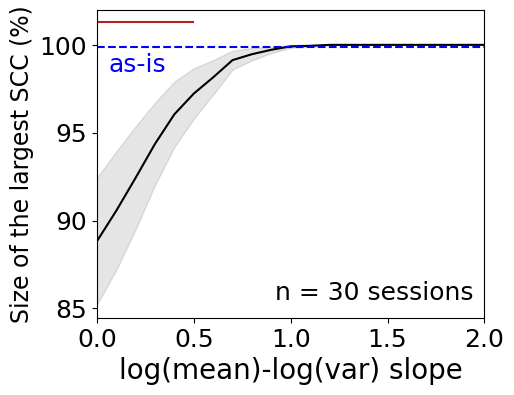

In [ ]:
# connected component

save_file_name = 'overlap_nbr_stimpairs_ABO_all22.pickle' # num_trial_types x num_trial_types, overlap (minimum distance) & gap (5% of 5nn average distance), with diagonal, slope 0-2
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
	overlap_stimpairs_ABO_all = pickle.load(f)
	
	list_mean_dist_mat = dc(overlap_stimpairs_ABO_all['list_mean_dist_mat'])
	list_overlap_asis2 = dc(overlap_stimpairs_ABO_all['list_overlap_asis2'])
	list_overlap_RRneuron3 = dc(overlap_stimpairs_ABO_all['list_overlap_RRneuron3'])
	
list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
num_sess = 32
num_trial_types = 119

# convert overlap matrix digonal to 0
for sess_ind in range(num_sess):
    list_overlap_asis2[sess_ind, np.eye(num_trial_types, dtype=bool)] = 0
    for slope_ind, target_slope in enumerate(list_target_slopes):
        list_overlap_RRneuron3[sess_ind, slope_ind, np.eye(num_trial_types, dtype=bool)] = 0

# as-is
list_size_scc_asis = np.zeros(num_sess)
for sess_ind in range(num_sess):
    # print(f'sess_ind = {sess_ind}')

    G_dir = nx.from_numpy_array(list_overlap_asis2[sess_ind], create_using=nx.DiGraph)
    
    # strongly connected component (SCC)
    sccs = nx.strongly_connected_components(G_dir)
    largest_scc = max(sccs, key=len)
    G_scc = G_dir.subgraph(largest_scc).copy()
    list_size_scc_asis[sess_ind] = len(list(G_scc.nodes)) / num_trial_types * 100 # percentage
    # print(f'Biggest SCC size = {len(list(G_scc.nodes))}')

# slope-changed
list_size_scc_RRneuron2 = np.zeros((num_sess, len(list_target_slopes)))
for sess_ind in range(num_sess):
    # print(f'sess_ind = {sess_ind}')

    for slope_ind, target_slope in enumerate(list_target_slopes):
        # print(f'target_slope = {target_slope}')

        G_dir = nx.from_numpy_array(list_overlap_RRneuron3[sess_ind, slope_ind], create_using=nx.DiGraph)
        
        # strongly connected component (SCC)
        sccs = nx.strongly_connected_components(G_dir)
        largest_scc = max(sccs, key=len)
        G_scc = G_dir.subgraph(largest_scc).copy()
        list_size_scc_RRneuron2[sess_ind, slope_ind] = len(list(G_scc.nodes)) / num_trial_types * 100 # percentage
        # print(f'Biggest SCC size = {len(list(G_scc.nodes))}')

# Exclude low quality sessions (0, 6)
list_size_scc_asis = np.concatenate([list_size_scc_asis[1:6], list_size_scc_asis[7:]], axis=0)
list_size_scc_RRneuron2 = np.concatenate([list_size_scc_RRneuron2[1:6], list_size_scc_RRneuron2[7:]], axis=0)

# Wilcoxon signed-rank test
list_pvals_size_scc_ABO = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_size_scc_ABO[slope_ind] = list(wilcoxon(list_size_scc_asis, list_size_scc_RRneuron2[:, slope_ind], nan_policy='omit'))[1]
list_pvals_size_scc_ABO = np.array(multipletests(list_pvals_size_scc_ABO, method='holm')[1]) # multiple comparisons correction
list_sig_slopes_size_scc = list_target_slopes[list_pvals_size_scc_ABO < 0.05].copy()

# line plot
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

list_means_size_scc = np.mean(list_size_scc_RRneuron2, axis=0)
list_errs_size_scc = sem(list_size_scc_RRneuron2, axis=0)

ax.plot(list_target_slopes, list_means_size_scc, color='k', label='SCC')
ax.fill_between(list_target_slopes, list_means_size_scc-list_errs_size_scc, list_means_size_scc+list_errs_size_scc, color='k', alpha=0.1)

# significance
# ax.set_ylim(ax.get_ylim()[0], 122)
ax.set_ylim(ax.get_ylim()[0], 102)
annotate_lineplot_significance(list_sig_slopes_size_scc, axes=ax, ax_ind=0, line_height_ratio=0.96, color='firebrick')
ax.axhline(np.mean(list_size_scc_asis), c='b', linestyle='--') # as-is average

# ax.set_yticks(list(np.arange(100, 120, 10)) + [119])
# ax.set_yticks(list(np.arange(100, 120, 10)) + [119])
ax.set_xlabel('log(mean)-log(var) slope', fontsize=20)
ax.set_ylabel(f'Size of the largest SCC (%)', fontsize=17)
ax.tick_params('both', labelsize=18)

# ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 12})
ax.set_xlim(0, 2)

height = (np.mean(list_size_scc_asis)-ax.get_ylim()[0]) / (ax.get_ylim()[1]-ax.get_ylim()[0])
ax.annotate('as-is', xy=(0.03, height-0.08), xycoords='axes fraction', fontsize=18, color='b')
ax.annotate(f'n = {list_size_scc_asis.shape[0]} sessions', xy=(0.46, 0.06), xycoords='axes fraction', fontsize=18, color='k')

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\scc.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\scc.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# # Collect correlation for each slope (within session)
# similarity_type = 'cos_sim'

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# n_neu_sampling = 10

# list_corr_withinsess3 = np.zeros((len(list_target_slopes), num_sess, n_neu_sampling, 3)) 
# for slope_ind, target_slope in enumerate(list_target_slopes):
#     file_name = 'RSM_corr_withinsess_ABO_shuf_' + similarity_type + str(slope_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         RSM_corr_withinsess_ABO = pickle.load(f)

#         if slope_ind == 0:
#             list_corr_withinsess_asis2 = RSM_corr_withinsess_ABO['list_corr_withinsess_asis2'].copy()
#         list_corr_withinsess3[slope_ind] = RSM_corr_withinsess_ABO['list_corr_withinsess2'].copy()

# save_file_name = 'RSM_corr_withinsess_ABO_shuf_all_' + similarity_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_corr_withinsess_asis2', 'list_corr_withinsess3'], \
#                  'list_corr_withinsess_asis2': list_corr_withinsess_asis2, 'list_corr_withinsess3': list_corr_withinsess3}, f)

## Figure 4C

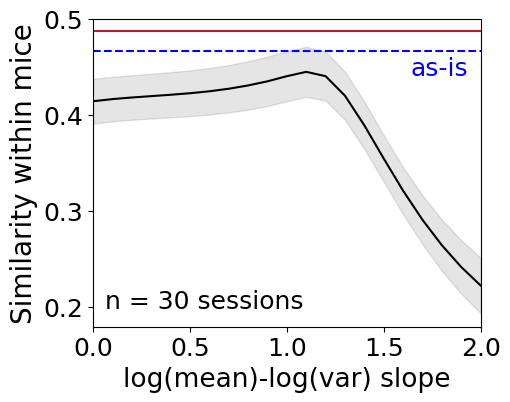

In [ ]:
similarity_type = 'cos_sim'

save_file_name = 'RSM_corr_withinsess_ABO_all_' + similarity_type + '.pickle' # slope -1~2, no as-is, trial permutation
save_file_name = 'RSM_corr_withinsess_ABO_all2_' + similarity_type + '.pickle' # slope 0~2, including as-is, trial combination
save_file_name = 'RSM_corr_withinsess_ABO_all3_' + similarity_type + '.pickle' # slope 0~2, including as-is, trial combination, neuron partioning matched
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_withinsess_ABO_all = pickle.load(f)
    list_corr_withinsess_asis2 = RSM_corr_withinsess_ABO_all['list_corr_withinsess_asis2'].copy()
    list_corr_withinsess3 = RSM_corr_withinsess_ABO_all['list_corr_withinsess3'].copy()

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

num_sess = 32

# Exclude low quality sessions (0, 6)
mask_06 = ~np.isin(range(num_sess), [0, 6])
list_corr_withinsess_asis2 = list_corr_withinsess_asis2[mask_06].copy()
list_corr_withinsess3 = list_corr_withinsess3[:, mask_06].copy()

# Wilcoxon signed-rank test (across session pairs)
list_pvals_corr_withinsess_ABO = np.full((3, len(list_target_slopes)), np.nan)
for corr_ind in range(3):
    pvals_temp = [list(wilcoxon(list_corr_withinsess_asis2[:, :, corr_ind].mean(axis=1), list_corr_withinsess3[slope_ind, :, :, corr_ind].mean(axis=1)))[1]\
                  for slope_ind in range(len(list_target_slopes))]
    pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
    list_pvals_corr_withinsess_ABO[corr_ind] = pvals_temp.copy()

corr_ind = 0
list_sig_slopes_corr_withinsess = list_target_slopes[list_pvals_corr_withinsess_ABO[corr_ind] < 0.05].copy()
# print(f'significant slope: {list_sig_slopes_corr_withinsess}')

# line plot

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_corr_withinsess = np.mean(list_corr_withinsess3[:, :, :, corr_ind], axis=(1, 2))
list_errs_corr_withinsess = sem(np.mean(list_corr_withinsess3[:, :, :, corr_ind], axis=2), axis=1)

axes[0].plot(list_target_slopes, list_means_corr_withinsess, color='k')
axes[0].fill_between(list_target_slopes, list_means_corr_withinsess-list_errs_corr_withinsess, \
                     list_means_corr_withinsess+list_errs_corr_withinsess, color='k', alpha=0.1)

# as-is
axes[0].axhline(np.mean(list_corr_withinsess_asis2[:, :, corr_ind]), c='b', linestyle='--', label='as-is')

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], 0.5)
annotate_lineplot_significance(list_sig_slopes_corr_withinsess, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=19)
# axes[0].set_ylabel('Similarity of RSMs\nbetween neuronal subsets', fontsize=17)
axes[0].set_ylabel('Similarity within mice', fontsize=20)
axes[0].tick_params('both', labelsize=18)
# axes[0].legend(loc='lower left', prop={'size': 12})
axes[0].set_xlim(0, 2)

height = (np.nanmean(list_corr_withinsess_asis2[:, :, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.82, height-0.08), xycoords='axes fraction', fontsize=18, color='b')
axes[0].annotate(f'n = {list_corr_withinsess_asis2.shape[0]} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\RSA_within.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\RSA_within.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure S4C middle

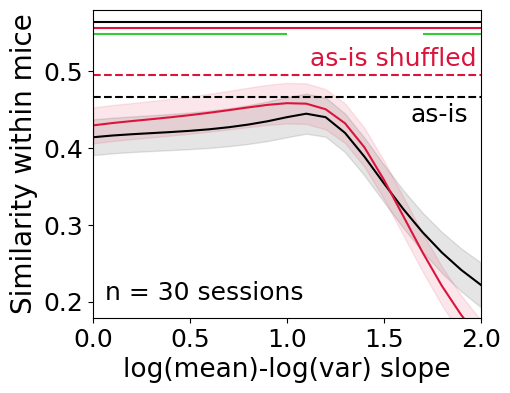

In [ ]:
similarity_type = 'cos_sim'

save_file_name = 'RSM_corr_withinsess_ABO_all_' + similarity_type + '.pickle' # slope -1~2, no as-is, trial permutation
save_file_name = 'RSM_corr_withinsess_ABO_all2_' + similarity_type + '.pickle' # slope 0~2, including as-is, trial combination
save_file_name = 'RSM_corr_withinsess_ABO_all3_' + similarity_type + '.pickle' # slope 0~2, including as-is, trial combination, neuron partioning matched
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_withinsess_ABO_all = pickle.load(f)
    list_corr_withinsess_asis2 = RSM_corr_withinsess_ABO_all['list_corr_withinsess_asis2'].copy()
    list_corr_withinsess3 = RSM_corr_withinsess_ABO_all['list_corr_withinsess3'].copy()

save_file_name = 'RSM_corr_withinsess_ABO_shuf_all_' + similarity_type + '.pickle' # slope 0~2, including as-is, trial combination, neuron partioning matched
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_withinsess_ABO_all = pickle.load(f)
    list_corr_withinsess_asis2_shuf = RSM_corr_withinsess_ABO_all['list_corr_withinsess_asis2'].copy()
    list_corr_withinsess3_shuf = RSM_corr_withinsess_ABO_all['list_corr_withinsess3'].copy()

list_target_slopes = np.linspace(-1, 2, 31, endpoint=True)
list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

num_sess = 32

# Exclude low quality sessions (0, 6)
mask_06 = ~np.isin(range(num_sess), [0, 6])
list_corr_withinsess_asis2 = list_corr_withinsess_asis2[mask_06].copy()
list_corr_withinsess3 = list_corr_withinsess3[:, mask_06].copy()
list_corr_withinsess_asis2_shuf = list_corr_withinsess_asis2_shuf[mask_06].copy()
list_corr_withinsess3_shuf = list_corr_withinsess3_shuf[:, mask_06].copy()

# Wilcoxon signed-rank test (across session pairs)
list_pvals_corr_withinsess_ABO = np.full((3, len(list_target_slopes)), np.nan)
list_pvals_corr_withinsess_ABO_shuf = np.full((3, len(list_target_slopes)), np.nan)
list_pvals_corr_withinsess_ABO_toshuf = np.full((3, len(list_target_slopes)), np.nan) # not-shuffled vs. shuffled
for corr_ind in range(3):
    pvals_temp = [list(wilcoxon(list_corr_withinsess_asis2[:, :, corr_ind].mean(axis=1), list_corr_withinsess3[slope_ind, :, :, corr_ind].mean(axis=1)))[1] \
                  for slope_ind in range(len(list_target_slopes))]
    pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
    list_pvals_corr_withinsess_ABO[corr_ind] = pvals_temp.copy()
    pvals_temp_shuf = [list(wilcoxon(list_corr_withinsess_asis2_shuf[:, :, corr_ind].mean(axis=1), list_corr_withinsess3_shuf[slope_ind, :, :, corr_ind].mean(axis=1)))[1] \
                       for slope_ind in range(len(list_target_slopes))]
    pvals_temp_shuf = np.array(multipletests(pvals_temp_shuf, method='holm')[1])
    list_pvals_corr_withinsess_ABO_shuf[corr_ind] = pvals_temp_shuf.copy()
    pvals_temp_toshuf = [list(wilcoxon(list_corr_withinsess3[slope_ind, :, :, corr_ind].mean(axis=1), list_corr_withinsess3_shuf[slope_ind, :, :, corr_ind].mean(axis=1)))[1] \
                         for slope_ind in range(len(list_target_slopes))]
    pvals_temp_toshuf = np.array(multipletests(pvals_temp_toshuf, method='holm')[1])
    list_pvals_corr_withinsess_ABO_toshuf[corr_ind] = pvals_temp_toshuf.copy()

corr_ind = 0
list_sig_slopes_corr_withinsess = list_target_slopes[list_pvals_corr_withinsess_ABO[corr_ind] < 0.05].copy()
list_sig_slopes_corr_withinsess_shuf = list_target_slopes[list_pvals_corr_withinsess_ABO_shuf[corr_ind] < 0.05].copy()
list_sig_slopes_corr_withinsess_toshuf = list_target_slopes[list_pvals_corr_withinsess_ABO_toshuf[corr_ind] < 0.05].copy()
# print(f'significant slope: {list_sig_slopes_corr_withinsess}')

# line plot

# 1. not shuffled

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_corr_withinsess = np.mean(list_corr_withinsess3[:, :, :, corr_ind], axis=(1, 2))
list_errs_corr_withinsess = sem(np.mean(list_corr_withinsess3[:, :, :, corr_ind], axis=2), axis=1)

axes[0].plot(list_target_slopes, list_means_corr_withinsess, color='k')
axes[0].fill_between(list_target_slopes, list_means_corr_withinsess-list_errs_corr_withinsess, \
                     list_means_corr_withinsess+list_errs_corr_withinsess, color='k', alpha=0.1)

# as-is
axes[0].axhline(np.mean(list_corr_withinsess_asis2[:, :, corr_ind]), c='k', linestyle='--', label='as-is')

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], 0.5)
axes[0].set_ylim(axes[0].get_ylim()[0], 0.58) # with shuffled
annotate_lineplot_significance(list_sig_slopes_corr_withinsess, axes=axes, ax_ind=0, line_height_ratio=0.96, color='k')

# 2. shuffled

list_means_corr_withinsess = np.mean(list_corr_withinsess3_shuf[:, :, :, corr_ind], axis=(1, 2))
list_errs_corr_withinsess = sem(np.mean(list_corr_withinsess3_shuf[:, :, :, corr_ind], axis=2), axis=1)

axes[0].plot(list_target_slopes, list_means_corr_withinsess, color='crimson')
axes[0].fill_between(list_target_slopes, list_means_corr_withinsess-list_errs_corr_withinsess, \
                     list_means_corr_withinsess+list_errs_corr_withinsess, color='crimson', alpha=0.1)

# as-is
axes[0].axhline(np.mean(list_corr_withinsess_asis2_shuf[:, :, corr_ind]), c='crimson', linestyle='--', label='as-is')

# significance
# axes[0].set_ylim(axes[0].get_ylim()[0], 0.5)
annotate_lineplot_significance(list_sig_slopes_corr_withinsess_shuf, axes=axes, ax_ind=0, line_height_ratio=0.94, color='crimson')
annotate_lineplot_significance(list_sig_slopes_corr_withinsess_toshuf, axes=axes, ax_ind=0, line_height_ratio=0.92, color='limegreen')

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=19)
# axes[0].set_ylabel('Similarity of RSMs\nbetween neuronal subsets', fontsize=17)
axes[0].set_ylabel('Similarity within mice', fontsize=20)
axes[0].tick_params('both', labelsize=18)
# axes[0].legend(loc='lower left', prop={'size': 12})

axes[0].set_xlim(0, 2)

height = (np.nanmean(list_corr_withinsess_asis2[:, :, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.82, height-0.08), xycoords='axes fraction', fontsize=18, color='k')
height_shuf = (np.nanmean(list_corr_withinsess_asis2_shuf[:, :, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is shuffled', xy=(0.56, height_shuf+0.03), xycoords='axes fraction', fontsize=18, color='crimson')
axes[0].annotate(f'n = {list_corr_withinsess_asis2.shape[0]} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

plt.show()

In [ ]:
# # Collect correlation for each slope (within-session, HVA)
# similarity_type = 'cos_sim'

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# n_neu_sampling = 10

# list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

# list_corr_withinsess_HVA2 = {hva: np.zeros((len(list_target_slopes), num_sess, n_neu_sampling, 3)) for hva in list_HVA_names}
# for area_ind, area in enumerate(list_HVA_names):
#     for slope_ind, target_slope in enumerate(list_target_slopes):
#         file_name = 'RSM_corr_withinsess_ABO_HVA_' + similarity_type + str(slope_ind) + '.pickle'

#         with open(file_name, 'rb') as f:
#             RSM_corr_withinsess_ABO = pickle.load(f)
#             if slope_ind == 0:
#                 list_corr_withinsess_asis_HVA = RSM_corr_withinsess_ABO['list_corr_withinsess_asis_HVA'].copy()

#             list_corr_withinsess_HVA2[area][slope_ind] = RSM_corr_withinsess_ABO['list_corr_withinsess_HVA'][area].copy()

# save_file_name = 'RSM_corr_withinsess_ABO_HVA_all_' + similarity_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_corr_withinsess_asis_HVA', 'list_corr_withinsess_HVA2'],
#                  'list_corr_withinsess_asis_HVA': list_corr_withinsess_asis_HVA, 'list_corr_withinsess_HVA2': list_corr_withinsess_HVA2}, f)

## Figure S6B

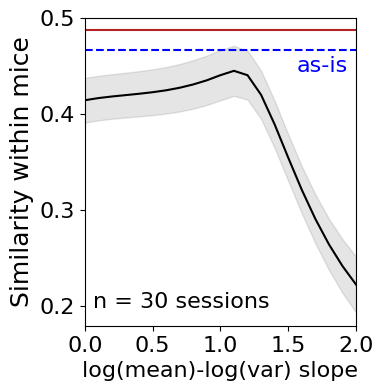

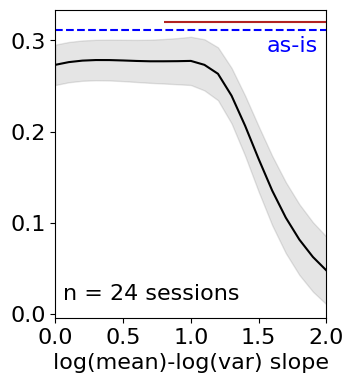

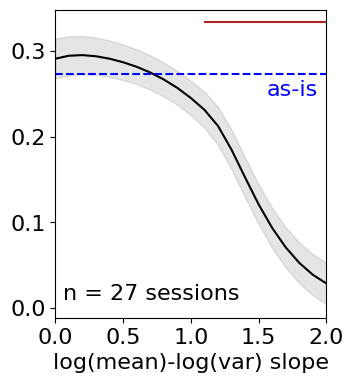

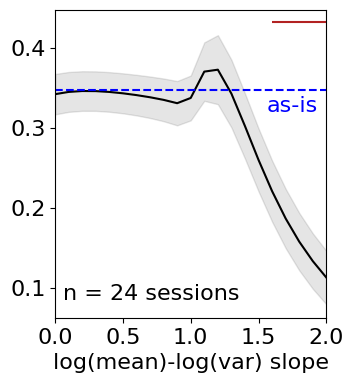

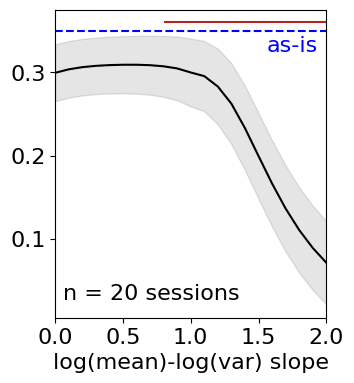

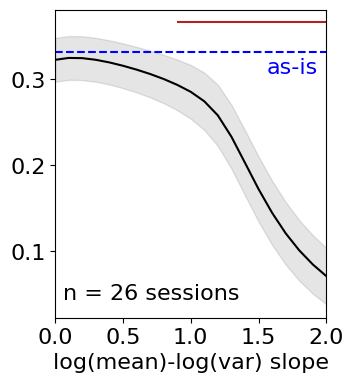

In [ ]:
# V1

similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_withinsess_ABO_all3_' + similarity_type + '.pickle' # slope 0~2, including as-is, trial combination, neuron partioning matched
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_withinsess_ABO_all = pickle.load(f)
    list_corr_withinsess_asis2 = RSM_corr_withinsess_ABO_all['list_corr_withinsess_asis2'].copy()
    list_corr_withinsess3 = RSM_corr_withinsess_ABO_all['list_corr_withinsess3'].copy()

num_sess = 32

# Exclude low quality sessions (0, 6)
mask_06 = ~np.isin(range(num_sess), [0, 6])
list_corr_withinsess_asis2 = list_corr_withinsess_asis2[mask_06].copy()
list_corr_withinsess3 = list_corr_withinsess3[:, mask_06].copy()

# Wilcoxon signed-rank test (across sessions)
list_pvals_corr_withinsess_ABO = np.full((3, len(list_target_slopes)), np.nan)
for corr_ind in range(3):
    pvals_temp = [list(wilcoxon(list_corr_withinsess_asis2[:, :, corr_ind].mean(axis=1), list_corr_withinsess3[slope_ind, :, :, corr_ind].mean(axis=1)))[1]\
                  for slope_ind in range(len(list_target_slopes))]
    pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
    list_pvals_corr_withinsess_ABO[corr_ind] = pvals_temp.copy()

corr_ind = 0
list_sig_slopes_corr_withinsess = list_target_slopes[list_pvals_corr_withinsess_ABO[corr_ind] < 0.05].copy()

# line plot

fig, axes = plt.subplots(1, 1, figsize=(3.5, 4))
axes = np.array(axes).flatten()

list_means_corr_withinsess = np.mean(list_corr_withinsess3[:, :, :, corr_ind], axis=(1, 2))
list_errs_corr_withinsess = sem(np.mean(list_corr_withinsess3[:, :, :, corr_ind], axis=2), axis=1)

axes[0].plot(list_target_slopes, list_means_corr_withinsess, color='k')
axes[0].fill_between(list_target_slopes, list_means_corr_withinsess-list_errs_corr_withinsess, \
                     list_means_corr_withinsess+list_errs_corr_withinsess, color='k', alpha=0.1)

# as-is
axes[0].axhline(np.mean(list_corr_withinsess_asis2[:, :, corr_ind]), c='b', linestyle='--', label='as-is')

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], 0.5)
annotate_lineplot_significance(list_sig_slopes_corr_withinsess, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=16)
# axes[0].set_ylabel('Similarity of RSMs\nbetween neuronal subsets', fontsize=17)
axes[0].set_ylabel('Similarity within mice', fontsize=18)
axes[0].tick_params('both', labelsize=16)
# axes[0].legend(loc='lower left', prop={'size': 12})

axes[0].set_xlim(0, 2)

height = (np.nanmean(list_corr_withinsess_asis2[:, :, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.78, height-0.07), xycoords='axes fraction', fontsize=16, color='b')
axes[0].annotate(f'n = {list_corr_withinsess_asis2.shape[0]} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=16, color='k')

plt.show()

# HVA

similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_withinsess_ABO_HVA_all_' + similarity_type + '.pickle' # trial order-matched (slope 0-2)
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_withinsess_ABO_all = pickle.load(f)

    list_corr_withinsess_asis_HVA = RSM_corr_withinsess_ABO_all['list_corr_withinsess_asis_HVA'].copy()
    list_corr_withinsess_HVA2 = RSM_corr_withinsess_ABO_all['list_corr_withinsess_HVA2'].copy()

with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_empty_sess2 = dc(resp_matrix_ep_HVA_allensdk['list_empty_sess2'])
    list_num_neurons_HVA = dc(resp_matrix_ep_HVA_allensdk['list_num_neurons_HVA'])

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

# Wilcoxon signed-rank test (across sessions)
list_pvals_corr_withinsess_ABO_HVA = {hva: 0 for hva in list_HVA_names}
for area_ind, area in enumerate(list_HVA_names):
    list_pvals_temp = np.full((3, len(list_target_slopes)), np.nan)
    for corr_ind in range(list_pvals_temp.shape[0]):
        pvals_temp = [list(wilcoxon(list_corr_withinsess_asis_HVA[area][:, :, corr_ind].mean(axis=1),
                                    list_corr_withinsess_HVA2[area][slope_ind, :, :, corr_ind].mean(axis=1), nan_policy='omit'))[1]
                                    for slope_ind in range(len(list_target_slopes))]
        pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
        list_pvals_temp[corr_ind] = pvals_temp.copy()
    list_pvals_corr_withinsess_ABO_HVA[area] = list_pvals_temp.copy()
corr_ind = 0

# line plot

for area_ind, area in enumerate(list_HVA_names):
    
    list_corr_withinsess_asis_HVA_temp = list_corr_withinsess_asis_HVA[area].copy()
    list_corr_withinsess_HVA2_temp = list_corr_withinsess_HVA2[area].copy()

    num_sess = 32

    # exclude low quality sessions & sessions without neurons
    mask_lowq = np.logical_and(~np.isin(range(num_sess), np.squeeze(np.argwhere(list_lowq_sess_HVA[area] > 0.1))),
                               ~np.isin(range(num_sess), np.squeeze(np.argwhere(list_num_neurons_HVA[area] == 0))))
    # print(np.squeeze(np.argwhere(list_lowq_sess_HVA[area] > 0.1)))
    # print(mask_lowq)

    list_corr_withinsess_asis_HVA_temp = list_corr_withinsess_asis_HVA[area][mask_lowq].copy()
    list_corr_withinsess_HVA2_temp = list_corr_withinsess_HVA2[area][:, mask_lowq].copy()

    # # session filtering based on number of neurons
    # sess_pairs = np.array(list(combinations(range(num_sess), 2)))
    # list_num_neurons = np.array(list_num_neurons_HVA[area]).copy()
    # # list_num_neurons = list_num_neurons[list_num_neurons > 0].copy()
    # sess_inds_qual40_all = np.arange(list_num_neurons.shape[0])[list_num_neurons >= 40]
    # mask_qualsess = np.all(np.isin(sess_pairs, sess_inds_qual40_all), axis=1)

    # list_corr_withinsess_asis_HVA_temp = list_corr_withinsess_asis_HVA[area][mask_qualsess].copy()
    # list_corr_withinsess_HVA2_temp = list_corr_withinsess_HVA2[area][:, mask_qualsess].copy()

    fig, axes = plt.subplots(1, 1, figsize=(3.5, 4))
    axes = np.array(axes).flatten()

    list_sig_slopes_corr_withinsess = list_target_slopes[list_pvals_corr_withinsess_ABO_HVA[area][corr_ind] < 0.05].copy()
    # print(f'significant slope: {list_sig_slopes_corr_withinsess}')

    list_means_corr_withinsess = np.nanmean(list_corr_withinsess_HVA2_temp[:, :, :, corr_ind], axis=(1, 2))
    list_errs_corr_withinsess = sem(list_corr_withinsess_HVA2_temp[:, :, :, corr_ind].mean(axis=2), axis=1, nan_policy='omit')

    line, = axes[0].plot(list_target_slopes, list_means_corr_withinsess, color='k')
    axes[0].fill_between(list_target_slopes, list_means_corr_withinsess-list_errs_corr_withinsess, \
                        list_means_corr_withinsess+list_errs_corr_withinsess, color='k', alpha=0.1)

    # as-is
    axes[0].axhline(np.nanmean(list_corr_withinsess_asis_HVA_temp[:, :, corr_ind]), color='blue', linestyle='--')

    # significance
    axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1]+0.015)
    # axes[0].set_ylim(0, 0.5)
    # axes[0].set_ylim(0.96, 1.01) # corr_ind = 2
    annotate_lineplot_significance(list_sig_slopes_corr_withinsess, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
    height = (np.nanmean(list_corr_withinsess_asis_HVA_temp[:, :, corr_ind]) - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
    axes[0].annotate('as-is', xy=(0.78, height-0.07), xycoords='axes fraction', fontsize=16, color='blue')
    axes[0].annotate(f'n = {len(list_corr_withinsess_asis_HVA_temp)} sessions', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=16, color='k')

    axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=16)
    # axes[0].set_ylabel('Similarity of RSM pair', fontsize=18)
    axes[0].tick_params('both', labelsize=16)
    # axes[0].set_yticks(np.arange(0.96, 1.01, 0.02)) # corr_ind = 2

    axes[0].set_xlim(0, 2)

    plt.show()

In [ ]:
# # Collect correlation for each slope
# similarity_type = 'cos_sim'

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# list_rate_RRneuron_dr2 = np.empty(len(list_target_slopes), dtype=object)
# list_RSM_mean_RRneuron2 = np.empty(len(list_target_slopes), dtype=object)
# list_corr_sesspair2 = np.zeros((len(list_target_slopes), math.comb(num_sess, 2), 3)) 
# for slope_ind, target_slope in enumerate(list_target_slopes):
#     file_name = 'RSM_corr_sesspair_ABO_allneu_' + similarity_type + str(slope_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         RSM_corr_sesspair_ABO = pickle.load(f)
#         if slope_ind == 0:
#             list_RSM_mean_asis_ABO = RSM_corr_sesspair_ABO['list_RSM_mean_asis'].copy()
#             list_corr_sesspair_asis_ABO = RSM_corr_sesspair_ABO['list_corr_sesspair_asis'].copy()

#         list_rate_RRneuron_dr2[slope_ind] = RSM_corr_sesspair_ABO['list_rate_RRneuron_dr'].copy()
#         list_RSM_mean_RRneuron2[slope_ind] = RSM_corr_sesspair_ABO['list_RSM_mean_RRneuron'].copy()
#         list_corr_sesspair2[slope_ind] = RSM_corr_sesspair_ABO['list_corr_sesspair'].copy()

# save_file_name = 'RSM_corr_sesspair_ABO_all_allneu2_' + similarity_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_RSM_mean_asis_ABO', 'list_corr_sesspair_asis_ABO', 'list_rate_RRneuron_dr2', 'list_RSM_mean_RRneuron2', 'list_corr_sesspair2'], \
#                  'list_RSM_mean_asis_ABO': list_RSM_mean_asis_ABO, 'list_corr_sesspair_asis_ABO': list_corr_sesspair_asis_ABO,
#                  'list_rate_RRneuron_dr2': list_rate_RRneuron_dr2, 'list_RSM_mean_RRneuron2': list_RSM_mean_RRneuron2, 'list_corr_sesspair2': list_corr_sesspair2}, f)

## Figure 4B

20 16


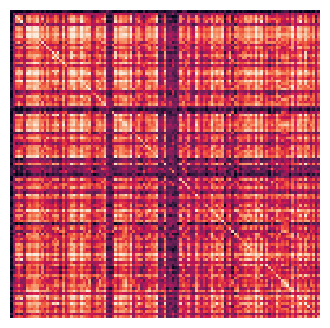

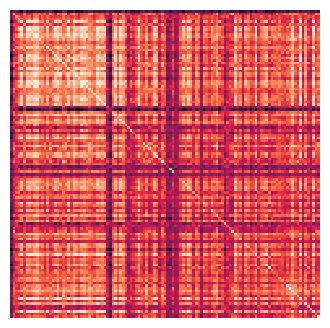

In [ ]:
# RSM heatmap for example sessions (as-is)

similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_sesspair_ABO_all_allneu2_' + similarity_type + '.pickle' # trial order-matched (slope 0-2)
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_sesspair_ABO_all = pickle.load(f)
    list_RSM_mean_asis_ABO = RSM_corr_sesspair_ABO_all['list_RSM_mean_asis_ABO'].copy()

num_sess = 32

sess_ind1, sess_ind2 = np.random.choice(range(num_sess), 2)
sess_ind1, sess_ind2 = 20, 16
print(sess_ind1, sess_ind2)


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = sns.heatmap(list_RSM_mean_asis_ABO[sess_ind1], vmin=0.6, vmax=0.8, cbar_kws=dict(ticks=np.arange(0.6, 0.85, 0.05)), cbar=False)
# ax.set_xlabel('Visual stimulus', fontsize=20)
# ax.set_ylabel('Visual stimulus', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=18)

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = sns.heatmap(list_RSM_mean_asis_ABO[sess_ind2], vmin=0.6, vmax=0.8, cbar_kws=dict(ticks=np.arange(0.6, 0.85, 0.05)), cbar=False)
# ax.set_xlabel('Visual stimulus', fontsize=20)
# ax.set_ylabel('Visual stimulus', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=18)

plt.show()

## Figure 4E

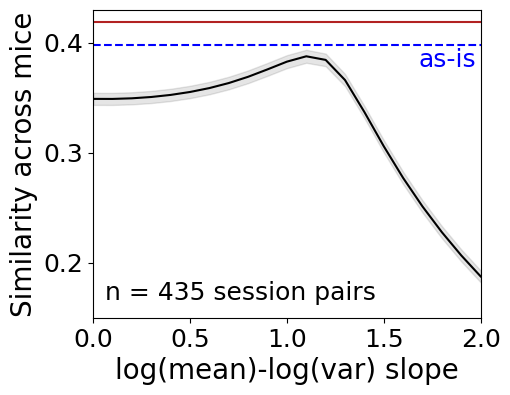

In [ ]:
similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_sesspair_ABO_all_allneu2_' + similarity_type + '.pickle' # trial order-matched (slope 0-2)
# save_file_name = 'RSM_corr_sesspair_ABO_all_allneu3_' + similarity_type + '.pickle' # trial order-matched (slope 0-2), without diagonal
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_sesspair_ABO_all = pickle.load(f)
    list_corr_sesspair_asis_ABO = RSM_corr_sesspair_ABO_all['list_corr_sesspair_asis_ABO'].copy()
    list_corr_sesspair2 = RSM_corr_sesspair_ABO_all['list_corr_sesspair2'].copy()

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
num_sess = 32

# Exclude low quality sessions (0, 6)
sess_pairs = np.array(list(combinations(range(num_sess), 2)))
mask_06 = ~np.any(np.isin(sess_pairs, [0, 6]), axis=1)

list_corr_sesspair_asis_ABO = list_corr_sesspair_asis_ABO[mask_06].copy()
list_corr_sesspair2 = list_corr_sesspair2[:, mask_06].copy()

# # session filtering based on number of neurons
# sess_pairs = np.array(list(combinations(range(num_sess), 2)))
# mask_qualsess = np.all(np.isin(sess_pairs, sess_inds_qual_all), axis=1)

# list_corr_sesspair_asis_ABO = list_corr_sesspair_asis_ABO[mask_qualsess].copy()
# list_corr_sesspair_asis_ABO_shuf = list_corr_sesspair_asis_ABO_shuf[mask_qualsess].copy()
# list_corr_sesspair2 = list_corr_sesspair2[:, mask_qualsess].copy()
# list_corr_sesspair2_shuf = list_corr_sesspair2_shuf[:, mask_qualsess].copy()

# Wilcoxon signed-rank test (across session pairs)
list_pvals_corr_sesspair_ABO = np.full((3, len(list_target_slopes)), np.nan)
for corr_ind in range(3):
    pvals_temp = [list(wilcoxon(list_corr_sesspair_asis_ABO[:, corr_ind], list_corr_sesspair2[slope_ind, :, corr_ind]))[1]\
                  for slope_ind in range(len(list_target_slopes))]
    pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
    list_pvals_corr_sesspair_ABO[corr_ind] = pvals_temp.copy()

corr_ind = 0
list_sig_slopes_corr_sesspair = list_target_slopes[list_pvals_corr_sesspair_ABO[corr_ind] < 0.05].copy()

# line plot
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_corr_sesspair = np.mean(list_corr_sesspair2[:, :, corr_ind], axis=1)
list_errs_corr_sesspair = sem(list_corr_sesspair2[:, :, corr_ind], axis=1)

axes[0].plot(list_target_slopes, list_means_corr_sesspair, color='k', label='original')
axes[0].fill_between(list_target_slopes, list_means_corr_sesspair-list_errs_corr_sesspair, \
                     list_means_corr_sesspair+list_errs_corr_sesspair, color='k', alpha=0.1)

# as-is
axes[0].axhline(np.nanmean(list_corr_sesspair_asis_ABO[:, corr_ind]), c='b', linestyle='--')

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
axes[0].set_ylim(0.15, 0.43)
annotate_lineplot_significance(list_sig_slopes_corr_sesspair, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
axes[0].set_yticks(np.arange(0.2, 0.42, 0.1))

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
# axes[0].set_ylabel('Similarity of RSMs\nbetween session pairs', fontsize=20)
axes[0].set_ylabel('Similarity across mice', fontsize=20)
axes[0].tick_params('both', labelsize=18)

height = (np.nanmean(list_corr_sesspair_asis_ABO[:, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.84, height-0.07), xycoords='axes fraction', fontsize=18, color='b')
axes[0].annotate(f'n = {list_corr_sesspair2.shape[1]} session pairs', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlim(0, 2)

plt.savefig('..\\..\\code_images\\neural_variability_robustness\\RSA_across.svg', bbox_inches='tight')
plt.savefig('..\\..\\code_images\\neural_variability_robustness\\RSA_across.png', dpi=300, bbox_inches='tight')
plt.show()

## Figure S4C right

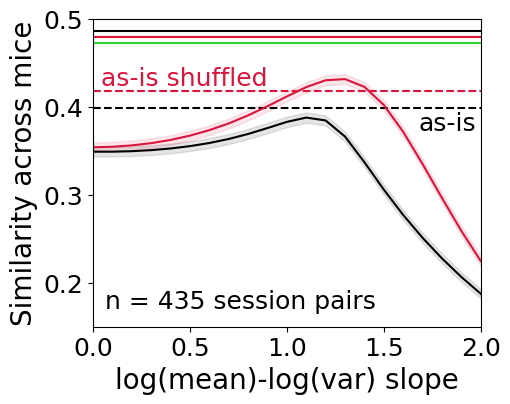

In [ ]:
similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_sesspair_ABO_all_allneu2_' + similarity_type + '.pickle' # trial order-matched (slope 0-2)
# save_file_name = 'RSM_corr_sesspair_ABO_all_allneu3_' + similarity_type + '.pickle' # trial order-matched (slope 0-2), without diagonal
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_sesspair_ABO_all = pickle.load(f)
    list_corr_sesspair_asis_ABO = RSM_corr_sesspair_ABO_all['list_corr_sesspair_asis_ABO'].copy()
    list_corr_sesspair2 = RSM_corr_sesspair_ABO_all['list_corr_sesspair2'].copy()

similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_sesspair_ABO_all_allneu_shuf_' + similarity_type + '.pickle'
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_sesspair_ABO_all = pickle.load(f)
    list_corr_sesspair_asis_ABO_shuf = RSM_corr_sesspair_ABO_all['list_corr_sesspair_asis_ABO_shuf'].copy()
    list_corr_sesspair2_shuf = RSM_corr_sesspair_ABO_all['list_corr_sesspair2_shuf'].copy()

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)
num_sess = 32

# Exclude low quality sessions (0, 6)
sess_pairs = np.array(list(combinations(range(num_sess), 2)))
mask_06 = ~np.any(np.isin(sess_pairs, [0, 6]), axis=1)

list_corr_sesspair_asis_ABO = list_corr_sesspair_asis_ABO[mask_06].copy()
list_corr_sesspair2 = list_corr_sesspair2[:, mask_06].copy()
list_corr_sesspair_asis_ABO_shuf = list_corr_sesspair_asis_ABO_shuf[mask_06].copy()
list_corr_sesspair2_shuf = list_corr_sesspair2_shuf[:, mask_06].copy()

# # session filtering based on number of neurons
# sess_pairs = np.array(list(combinations(range(num_sess), 2)))
# mask_qualsess = np.all(np.isin(sess_pairs, sess_inds_qual_all), axis=1)

# list_corr_sesspair_asis_ABO = list_corr_sesspair_asis_ABO[mask_qualsess].copy()
# list_corr_sesspair_asis_ABO_shuf = list_corr_sesspair_asis_ABO_shuf[mask_qualsess].copy()
# list_corr_sesspair2 = list_corr_sesspair2[:, mask_qualsess].copy()
# list_corr_sesspair2_shuf = list_corr_sesspair2_shuf[:, mask_qualsess].copy()

# Wilcoxon signed-rank test (across session pairs)
list_pvals_corr_sesspair_ABO = np.full((3, len(list_target_slopes)), np.nan)
list_pvals_corr_sesspair_ABO_shuf = np.full((3, len(list_target_slopes)), np.nan)
list_pvals_corr_sesspair_ABO_toshuf = np.full((3, len(list_target_slopes)), np.nan) # not-shuffled vs. shuffled
for corr_ind in range(3):
    pvals_temp = [list(wilcoxon(list_corr_sesspair_asis_ABO[:, corr_ind], list_corr_sesspair2[slope_ind, :, corr_ind]))[1] \
                  for slope_ind in range(len(list_target_slopes))]
    pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
    list_pvals_corr_sesspair_ABO[corr_ind] = pvals_temp.copy()
    pvals_temp_shuf = [list(wilcoxon(list_corr_sesspair_asis_ABO_shuf[:, corr_ind], list_corr_sesspair2_shuf[slope_ind, :, corr_ind]))[1] \
                       for slope_ind in range(len(list_target_slopes))]
    pvals_temp_shuf = np.array(multipletests(pvals_temp_shuf, method='holm')[1])
    list_pvals_corr_sesspair_ABO_shuf[corr_ind] = pvals_temp_shuf.copy()
    pvals_temp_toshuf = [list(wilcoxon(list_corr_sesspair2[slope_ind, :, corr_ind], list_corr_sesspair2_shuf[slope_ind, :, corr_ind]))[1] \
                         for slope_ind in range(len(list_target_slopes))]
    pvals_temp_toshuf = np.array(multipletests(pvals_temp_toshuf, method='holm')[1])
    list_pvals_corr_sesspair_ABO_toshuf[corr_ind] = pvals_temp_toshuf.copy()

corr_ind = 0
list_sig_slopes_corr_sesspair = list_target_slopes[list_pvals_corr_sesspair_ABO[corr_ind] < 0.05].copy()
list_sig_slopes_corr_sesspair_shuf = list_target_slopes[list_pvals_corr_sesspair_ABO_shuf[corr_ind] < 0.05].copy()
list_sig_slopes_corr_sesspair_toshuf = list_target_slopes[list_pvals_corr_sesspair_ABO_toshuf[corr_ind] < 0.05].copy()

# line plot
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

# 1. not shuffled

list_means_corr_sesspair = np.mean(list_corr_sesspair2[:, :, corr_ind], axis=1)
list_errs_corr_sesspair = sem(list_corr_sesspair2[:, :, corr_ind], axis=1)

axes[0].plot(list_target_slopes, list_means_corr_sesspair, color='k', label='original')
axes[0].fill_between(list_target_slopes, list_means_corr_sesspair-list_errs_corr_sesspair, \
                     list_means_corr_sesspair+list_errs_corr_sesspair, color='k', alpha=0.1)

# as-is
axes[0].axhline(np.nanmean(list_corr_sesspair_asis_ABO[:, corr_ind]), c='k', linestyle='--')

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
axes[0].set_ylim(0.15, 0.43)
axes[0].set_ylim(0.15, 0.5) # with shuffled
annotate_lineplot_significance(list_sig_slopes_corr_sesspair, axes=axes, ax_ind=0, line_height_ratio=0.96, color='k')
axes[0].set_yticks(np.arange(0.2, 0.42, 0.1))
axes[0].set_yticks(np.arange(0.2, 0.52, 0.1)) # with shuffled

# 2. shuffled

list_means_corr_sesspair = np.mean(list_corr_sesspair2_shuf[:, :, corr_ind], axis=1)
list_errs_corr_sesspair = sem(list_corr_sesspair2_shuf[:, :, corr_ind], axis=1)

axes[0].plot(list_target_slopes, list_means_corr_sesspair, color='crimson', label='shuffled')
axes[0].fill_between(list_target_slopes, list_means_corr_sesspair-list_errs_corr_sesspair, \
                     list_means_corr_sesspair+list_errs_corr_sesspair, color='crimson', alpha=0.1)

# as-is
axes[0].axhline(np.nanmean(list_corr_sesspair_asis_ABO_shuf[:, corr_ind]), c='crimson', linestyle='--')

# significance
# axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
# axes[0].set_ylim(0.15, 0.45)
annotate_lineplot_significance(list_sig_slopes_corr_sesspair_shuf, axes=axes, ax_ind=0, line_height_ratio=0.94, color='crimson')
annotate_lineplot_significance(list_sig_slopes_corr_sesspair_toshuf, axes=axes, ax_ind=0, line_height_ratio=0.92, color='limegreen') # not-shuffled vs. shuffled

# axes[0].set_title('Natural Scenes Neuropixels', fontsize=19)
axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
# axes[0].set_ylabel('Similarity of RSMs\nbetween session pairs', fontsize=20)
axes[0].set_ylabel('Similarity across mice', fontsize=20)
axes[0].tick_params('both', labelsize=18)
# axes[0].set_yticks(np.arange(0.15, 0.8, 0.2))

# axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 15})
height = (np.nanmean(list_corr_sesspair_asis_ABO[:, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.84, height-0.07), xycoords='axes fraction', fontsize=18, color='k')
height_shuf = (np.nanmean(list_corr_sesspair_asis_ABO_shuf[:, corr_ind])-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is shuffled', xy=(0.02, height_shuf+0.02), xycoords='axes fraction', fontsize=18, color='crimson')
axes[0].annotate(f'n = {list_corr_sesspair2.shape[1]} session pairs', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlim(0, 2)

plt.show()

In [ ]:
# # Collect correlation for each slope (HVA)
# similarity_type = 'cos_sim'

# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32

# list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

# list_RSM_mean_RRneuron_HVA2 = {hva: np.empty(len(list_target_slopes), dtype=object) for hva in list_HVA_names}
# list_rate_RRneuron_dr_HVA2 = {hva: np.empty(len(list_target_slopes), dtype=object) for hva in list_HVA_names}
# list_corr_sesspair_HVA2 = {hva: np.zeros((len(list_target_slopes), math.comb(num_sess, 2), 3)) for hva in list_HVA_names}
# for area_ind, area in enumerate(list_HVA_names):
#     for slope_ind, target_slope in enumerate(list_target_slopes):
#         file_name = 'RSM_corr_sesspair_ABO_HVA_allneu_' + similarity_type + str(slope_ind) + '.pickle'

#         with open(file_name, 'rb') as f:
#             RSM_corr_sesspair_ABO = pickle.load(f)
#             if slope_ind == 0:
#                 list_RSM_mean_asis_HVA = RSM_corr_sesspair_ABO['list_RSM_mean_asis_HVA'].copy()
#                 list_corr_sesspair_asis_HVA = RSM_corr_sesspair_ABO['list_corr_sesspair_asis_HVA'].copy()

#             list_rate_RRneuron_dr_HVA2[area][slope_ind] = RSM_corr_sesspair_ABO['list_rate_RRneuron_dr_HVA'][area].copy()
#             list_RSM_mean_RRneuron_HVA2[area][slope_ind] = RSM_corr_sesspair_ABO['list_RSM_mean_RRneuron_HVA'][area].copy()
#             list_corr_sesspair_HVA2[area][slope_ind] = RSM_corr_sesspair_ABO['list_corr_sesspair_HVA'][area].copy()

# save_file_name = 'RSM_corr_sesspair_ABO_HVA_all_allneu2_' + similarity_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_rate_RRneuron_dr_HVA2', 'list_RSM_mean_asis_HVA', 'list_RSM_mean_RRneuron_HVA2', 'list_corr_sesspair_asis_HVA', 'list_corr_sesspair_HVA2'], \
#                     'list_rate_RRneuron_dr_HVA2': list_rate_RRneuron_dr_HVA2, 'list_RSM_mean_asis_HVA': list_RSM_mean_asis_HVA, 'list_RSM_mean_RRneuron_HVA2': list_RSM_mean_RRneuron_HVA2,
#                     'list_corr_sesspair_asis_HVA': list_corr_sesspair_asis_HVA, 'list_corr_sesspair_HVA2': list_corr_sesspair_HVA2}, f)

## Figure S6C

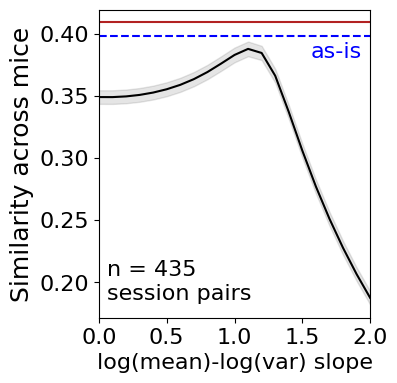

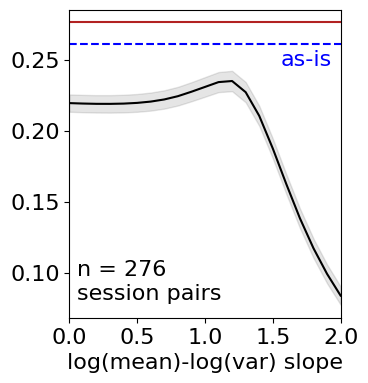

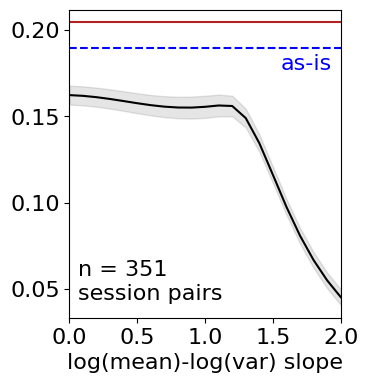

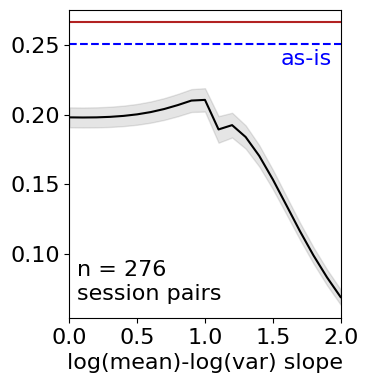

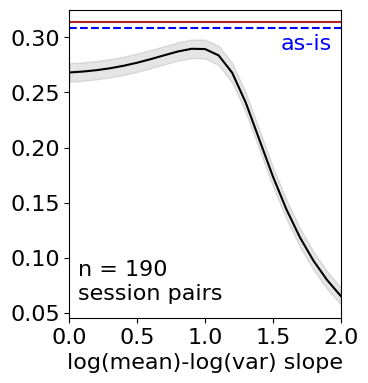

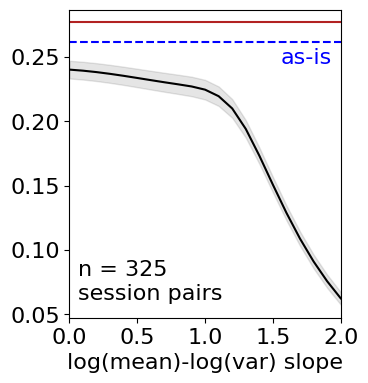

In [ ]:
# V1

similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_sesspair_ABO_all_allneu2_' + similarity_type + '.pickle' # trial order-matched (slope 0-2)
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_sesspair_ABO_all = pickle.load(f)
    
    list_corr_sesspair_asis_ABO = RSM_corr_sesspair_ABO_all['list_corr_sesspair_asis_ABO'].copy()
    list_corr_sesspair2 = RSM_corr_sesspair_ABO_all['list_corr_sesspair2'].copy()

num_sess = 32

# Exclude low quality sessions (0, 6)
sess_pairs = np.array(list(combinations(range(num_sess), 2)))
mask_06 = ~np.any(np.isin(sess_pairs, [0, 6]), axis=1)

list_corr_sesspair_asis_ABO = list_corr_sesspair_asis_ABO[mask_06].copy()
list_corr_sesspair2 = list_corr_sesspair2[:, mask_06].copy()

# # session filtering based on number of neurons
# sess_pairs = np.array(list(combinations(range(num_sess), 2)))
# list_num_neurons = np.array([list_rate_all[sess_ind].shape[0] for sess_ind in range(num_sess)])
# sess_inds_qual40_all = np.arange(list_num_neurons.shape[0])[list_num_neurons >= 40]
# mask_qualsess = np.all(np.isin(sess_pairs, sess_inds_qual40_all), axis=1)

# list_corr_sesspair_asis_ABO = list_corr_sesspair_asis_ABO[mask_qualsess].copy()
# list_corr_sesspair2 = list_corr_sesspair2[:, mask_qualsess].copy()

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# Wilcoxon signed-rank test (across session pairs)
list_pvals_corr_sesspair_ABO = np.full((3, len(list_target_slopes)), np.nan)
for corr_ind in range(3):
    pvals_temp = [list(wilcoxon(list_corr_sesspair_asis_ABO[:, corr_ind], list_corr_sesspair2[slope_ind, :, corr_ind]))[1]\
                  for slope_ind in range(len(list_target_slopes))]
    pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
    list_pvals_corr_sesspair_ABO[corr_ind] = pvals_temp.copy()

corr_ind = 0

list_sig_slopes_corr_sesspair = list_target_slopes[list_pvals_corr_sesspair_ABO[corr_ind] < 0.05].copy()
# print(f'significant slope: {list_sig_slopes_corr_sesspair}')

# line plot
fig, axes = plt.subplots(1, 1, figsize=(3.5, 4))
axes = np.array(axes).flatten()

list_means_corr_sesspair = np.mean(list_corr_sesspair2[:, :, corr_ind], axis=1)
list_errs_corr_sesspair = sem(list_corr_sesspair2[:, :, corr_ind], axis=1)

axes[0].plot(list_target_slopes, list_means_corr_sesspair, color='k')
axes[0].fill_between(list_target_slopes, list_means_corr_sesspair-list_errs_corr_sesspair, \
                     list_means_corr_sesspair+list_errs_corr_sesspair, color='k', alpha=0.1)

# as-is
axes[0].axhline(np.nanmean(list_corr_sesspair_asis_ABO[:, corr_ind]), c='blue', linestyle='--')

# significance
axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1]+0.015)
# axes[0].set_ylim(0, 0.5)
annotate_lineplot_significance(list_sig_slopes_corr_sesspair, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
height = (np.nanmean(list_corr_sesspair_asis_ABO[:, corr_ind]) - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.78, height-0.07), xycoords='axes fraction', fontsize=16, color='blue')
axes[0].annotate(f'n = {list_corr_sesspair2.shape[1]}\nsession pairs', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=16, color='k')

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=16)
# axes[0].set_ylabel('Similarity of RSM pair', fontsize=18)
axes[0].set_ylabel('Similarity across mice', fontsize=18)
axes[0].tick_params('both', labelsize=16)
# axes[0].set_yticks(np.arange(0.96, 1.01, 0.02)) # corr_ind = 2

axes[0].set_xlim(0, 2)

plt.show()

# HVA

similarity_type = 'cos_sim'
save_file_name = 'RSM_corr_sesspair_ABO_HVA_all_allneu_' + similarity_type + '.pickle'
save_file_name = 'RSM_corr_sesspair_ABO_HVA_all_allneu2_' + similarity_type + '.pickle' # trial order-matched (slope 0-2)
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    RSM_corr_sesspair_ABO_all = pickle.load(f)

    list_corr_sesspair_asis_HVA = RSM_corr_sesspair_ABO_all['list_corr_sesspair_asis_HVA'].copy()
    list_corr_sesspair_HVA2 = RSM_corr_sesspair_ABO_all['list_corr_sesspair_HVA2'].copy()

with open('resp_matrix_ep_HVA_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_HVA_allensdk = pickle.load(f)

    list_empty_sess2 = dc(resp_matrix_ep_HVA_allensdk['list_empty_sess2'])
    list_num_neurons_HVA = dc(resp_matrix_ep_HVA_allensdk['list_num_neurons_HVA'])

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

list_HVA_names = ['VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

# Wilcoxon signed-rank test (across session pairs)
list_pvals_corr_sesspair_ABO_HVA = {hva: 0 for hva in list_HVA_names}
for area_ind, area in enumerate(list_HVA_names):
    list_pvals_temp = np.full((3, len(list_target_slopes)), np.nan)
    for corr_ind in range(list_pvals_temp.shape[0]):
        pvals_temp = [list(wilcoxon(list_corr_sesspair_asis_HVA[area][:, corr_ind],
                                    list_corr_sesspair_HVA2[area][slope_ind, :, corr_ind], nan_policy='omit'))[1]
                                    for slope_ind in range(len(list_target_slopes))]
        pvals_temp = np.array(multipletests(pvals_temp, method='holm')[1]) # multiple comparisons correction
        list_pvals_temp[corr_ind] = pvals_temp.copy()
    list_pvals_corr_sesspair_ABO_HVA[area] = list_pvals_temp.copy()
corr_ind = 0

# line plot

for area_ind, area in enumerate(list_HVA_names):
    
    list_corr_sesspair_asis_HVA_temp = list_corr_sesspair_asis_HVA[area].copy()
    list_corr_sesspair_HVA2_temp = list_corr_sesspair_HVA2[area].copy()

    num_sess = 32

    # exclude low quality sessions & sessions without neurons
    sess_pairs = np.array(list(combinations(range(num_sess), 2)))
    mask_lowq = np.logical_and(~np.any(np.isin(sess_pairs, np.squeeze(np.argwhere(list_lowq_sess_HVA[area] > 0.1))), axis=1),
                               ~np.any(np.isin(sess_pairs, np.squeeze(np.argwhere(list_num_neurons_HVA[area] == 0))), axis=1))
    # print(np.squeeze(np.argwhere(list_lowq_sess_HVA[area] > 0.1)))
    # print(mask_lowq)

    list_corr_sesspair_asis_HVA_temp = list_corr_sesspair_asis_HVA[area][mask_lowq].copy()
    list_corr_sesspair_HVA2_temp = list_corr_sesspair_HVA2[area][:, mask_lowq].copy()

    # # session filtering based on number of neurons
    # sess_pairs = np.array(list(combinations(range(num_sess), 2)))
    # list_num_neurons = np.array(list_num_neurons_HVA[area]).copy()
    # # list_num_neurons = list_num_neurons[list_num_neurons > 0].copy()
    # sess_inds_qual40_all = np.arange(list_num_neurons.shape[0])[list_num_neurons >= 40]
    # mask_qualsess = np.all(np.isin(sess_pairs, sess_inds_qual40_all), axis=1)

    # list_corr_sesspair_asis_HVA_temp = list_corr_sesspair_asis_HVA[area][mask_qualsess].copy()
    # list_corr_sesspair_HVA2_temp = list_corr_sesspair_HVA2[area][:, mask_qualsess].copy()

    fig, axes = plt.subplots(1, 1, figsize=(3.5, 4))
    axes = np.array(axes).flatten()

    list_sig_slopes_corr_sesspair = list_target_slopes[list_pvals_corr_sesspair_ABO_HVA[area][corr_ind] < 0.05].copy()
    # print(f'significant slope: {list_sig_slopes_corr_sesspair}')

    list_means_corr_sesspair = np.nanmean(list_corr_sesspair_HVA2_temp[:, :, corr_ind], axis=1)
    list_errs_corr_sesspair = sem(list_corr_sesspair_HVA2_temp[:, :, corr_ind], axis=1, nan_policy='omit')

    line, = axes[0].plot(list_target_slopes, list_means_corr_sesspair, color='k')
    axes[0].fill_between(list_target_slopes, list_means_corr_sesspair-list_errs_corr_sesspair, \
                        list_means_corr_sesspair+list_errs_corr_sesspair, color='k', alpha=0.1)

    # as-is
    axes[0].axhline(np.nanmean(list_corr_sesspair_asis_HVA_temp[:, corr_ind]), color='blue', linestyle='--')

    # significance
    axes[0].set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1]+0.015)
    # axes[0].set_ylim(0, 0.5)
    # axes[0].set_ylim(0.96, 1.01) # corr_ind = 2
    annotate_lineplot_significance(list_sig_slopes_corr_sesspair, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
    height = (np.nanmean(list_corr_sesspair_asis_HVA_temp[:, corr_ind]) - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
    axes[0].annotate('as-is', xy=(0.78, height-0.07), xycoords='axes fraction', fontsize=16, color='blue')
    axes[0].annotate(f'n = {len(list_corr_sesspair_asis_HVA_temp)}\nsession pairs', xy=(0.03, 0.06), xycoords='axes fraction', fontsize=16, color='k')

    axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=16)
    # axes[0].set_ylabel('Similarity of RSM pair', fontsize=18)
    axes[0].tick_params('both', labelsize=16)
    # axes[0].set_yticks(np.arange(0.96, 1.01, 0.02)) # corr_ind = 2

    axes[0].set_xlim(0, 2)

    plt.show()